ANLY 5336: Analytics w/ Dr. Emily Zhu\
Assignment 1\
Author: John Courtright\
Date: 9/10/2025\
Brief: Working with Airbnb & data from Washington Posts's "Game of Thrones" death database to create boxplots, histograms, scatterplots, word clouds, and handle missing data and outliers

In [ ]:
# Required Libaries
import pandas as pd
import numpy as np
import seaborn as sns # Used for visualization
# Seaborn instead of matplotlib
# Growing popularlity in industry
# Also learning it w/ Dr. Mendez for GIA role
import matplotlib.pyplot as plt # Used for viz titles

Part 1: Airbnb listing longevity\
Dataset: listing_host_start.csv\
Data Source: http://insideairbnb.com/get-the-data.html\
Data Dictionary: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=1322284596#gid=132228459\
Date Updated (According to Source Page): June 13, 2025

In [2]:
# Read in Airbnb listing from local csv
airbnb_df = pd.read_csv('Datasets/listing_host_start.csv')
airbnb_df.head() # Check if read in correctly

,host_id,host_since,host_is_superhost,update,start_month,host_duration
0,4635658,2013-01-08,t,2019-05-31,1.0,2334.0
1,2466,2008-08-23,t,2019-05-31,8.0,3933.0
2,2466,2008-08-23,t,2019-05-31,8.0,3933.0
3,8028,2009-02-16,t,2019-05-31,2.0,3756.0
4,8186,2009-02-19,t,2019-05-31,2.0,3753.0


To determine outliers, we can calculate them by hand using the Tukey IQR formula, defined a function with the Tukey formula, or use the Kernel Density Estimation function.

The Tukey Function is best suited for normal distributions that either follow the bell-curve or have some left-right skew. 

The KDE Function is better for bimodal distributions. The Airbnb data in this analysis is skewed to the right (median < mean), so the Tukey method will be used. 

Q1: 954.0, Median: 1538.0, Q3: 2156.0, IQR: 1202.0
Lower Bound: -849.0, Upper Bound: 3959.0
Outlier host_ids:
       host_id  host_duration
7720        23         4106.0
10827       23         4106.0


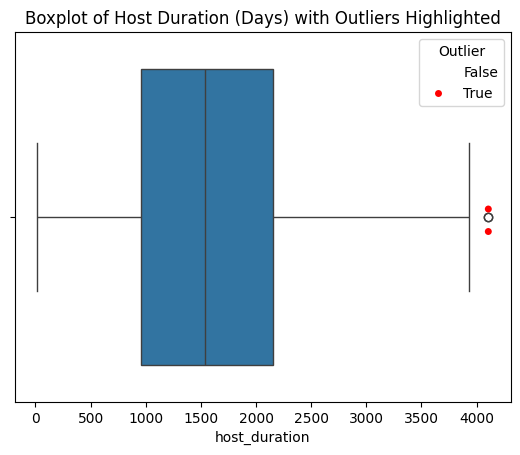

In [3]:
# Boxplot of "host_duration"

# host_duration is a calculated field, not found in the original dataset
# It is the number of days between hosts' start and May 31, 2019

# We can use the Tukey or KDE functions (below), but I want to use the variables
# in this cell to visualization + tracking values
# Doing outlier detection by hand with Tukey method

# Calculate Q1, Q3, and IQR
Q1 = airbnb_df['host_duration'].quantile(0.25)
Q3 = airbnb_df['host_duration'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print QI, Q3, IQR, and bounds for reference
median = airbnb_df['host_duration'].median()
print(f"Q1: {Q1}, Median: {median}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Create 'outlier' column
airbnb_df['outlier'] = (
    (airbnb_df['host_duration'] < lower_bound) |
    (airbnb_df['host_duration'] > upper_bound)
)
                       
# Outerliers DataFrame
outliers = airbnb_df[airbnb_df['outlier'] == True]

# Print outlier host_ids
print("Outlier host_ids:")
print(outliers[['host_id', 'host_duration']])

# Plot: normal values in blue, outliers in red
sns.boxplot(data = airbnb_df, 
            x = 'host_duration')
sns.stripplot(data = airbnb_df, 
            x = 'host_duration', 
            hue = 'outlier', # Different color for outliers
            palette = {True: 'red'})

plt.title('Boxplot of Host Duration (Days) with Outliers Highlighted')
plt.legend(title='Outlier', loc='upper right')
plt.show()

This boxplot visualizes host_duration, including the outliers of the original data set. 

The 1st quartile is 954.0 days. The 2nd quartile (the median) is 1538.0 days. The 3rd quartile is 2156.0 days. The IQR is 1202.0. The lower bound is negative, meaning there are no outliers in the negative direction. The upper bound is 3959.0, and there are two records past that. The two outliers, being record 7720 and 10827, share the same host_id and host_duration. This means that the listing is operated by the same host and was listed at the same time as the other. 

The distribution of host durations is relatively stable, with half of hosts active between 2.6 and 5.9 years. The data has minimal outlier influence, as only two records slightly exceed the upper bound at ~11 years. This suggests that while a small minority of hosts have been active for over a decade, the vast majority fall within a consistent and typical range of activity. 

From a business standpoint, these results suggest that most Airbnb hosts have multi-year longevity, with the majority active for 2.5 to 6 years. This means that most hosts have a good level of experience and stability. The outlier cases, while few, could present a good opportunity for case studies to understand their hosting habits. 

In [4]:
# Tukey IQR Function provided by Dr. Zhu
# Takes a column from a dataframe as input 'x'
# Return list of outlier indices and list of outlier values
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    floor = q1 - 1.5 * iqr
    ceiling = q3 + 1.5 * iqr
    outlier_indices = list(x.index[(x < floor) | (x > ceiling)])
    outlier_values = list(x[(x < floor) | (x > ceiling)])
    return outlier_indices, outlier_values

In [5]:
# Kernel Density Estimation Function provided by Dr. Zhu
from sklearn.preprocessing import scale
from statsmodels.nonparametric.kde import KDEUnivariate

# Takes a column from a dataframe as input 'x'
# Return list of outlier indices and list of outlier values
def find_outliers_kde(x):
    x_scaled = scale(list(map(float,x))) # Scale the data
    kde = KDEUnivariate(x_scaled) # Create the KDE object
    kde.fit(bw = 'scott', ftt = True) # Fit the data
    pred = kde.evaluate(x_scaled) # Evaluate the density on the data points
    
    n = sum(pred < 0.05) # Define outliers as those with density < 0.05
    outlier_ind = np.asarray(pred).argsort()[:n] # Get the indices of the outliers
    outlier_value = np.asarray(x)[outlier_ind] # Get the values of the outliers
    
    return outlier_ind, outlier_value

In [6]:
# Create a new dataframe to hold a copy of the data
# Excluding outliers based on host_duration
clean_df = airbnb_df[airbnb_df['outlier'] == False]

# Can also be done with the Tukey function
# tukey_indices, tukey_values = find_outliers_tukey(airbnb_df['host_duration'])
# df_new = airbnb_df[~airbnb_df.index.isin(tukey_indices)]

# Can also be done with the KDE function
# kde_indices, kde_values = find_outliers_kde(airbnb_df['host_duration'])
# df_new = airbnb_df[~airbnb_df.index.isin(kde_indices)]    

# Like mentioned before, the KDE function works better for bimodal distributions
# The Airbnb data is right-skewed, so the Tukey method is more appropriate
# My method was calculating the outliers by hand, then creating a new boolean 'outlier' column
# I just wanted to use the related variables to help visualize and print out

# Check shape of both dataframes
print("Original DataFrame shape:", airbnb_df.shape)
print("DataFrame without outliers shape:", clean_df.shape)

# We know there are two outliers, so the new dataframe should have two fewer rows
print("Number of outliers removed:", airbnb_df.shape[0] - clean_df.shape[0])

Original DataFrame shape: (11792, 7)
DataFrame without outliers shape: (11790, 7)
Number of outliers removed: 2


In [7]:
# Calculate the mean and stanard deviation of hosting days including outliers
mean_duration_all = airbnb_df['host_duration'].mean()
std_duration_all = airbnb_df['host_duration'].std()

print(f"Mean Hosting Duration (including outliers): {mean_duration_all:.2f} days")
print(f"Standard Deviation of Hosting Duration (including outliers): {std_duration_all:.2f} days")

# Do both for comparison

# Calculate the mean and standard deviation of hosting days excluding outliers
mean_duration = clean_df['host_duration'].mean()
std_duration = clean_df['host_duration'].std()

print(f"Mean Hosting Duration (excluding outliers): {mean_duration:.2f} days")
print(f"Standard Deviation of Hosting Duration (excluding outliers): {std_duration:.2f} days")

Mean Hosting Duration (including outliers): 1562.38 days
Standard Deviation of Hosting Duration (including outliers): 794.35 days
Mean Hosting Duration (excluding outliers): 1561.95 days
Standard Deviation of Hosting Duration (excluding outliers): 793.73 days


Mean Hosting Duration (excluding outliers): 1561.95 days
Median Hosting Duration (excluding outliers): 1538.00 days
Difference between Mean and Median: 23.95 days
Most Frequent Hosting Duration (bin): 822.0 days


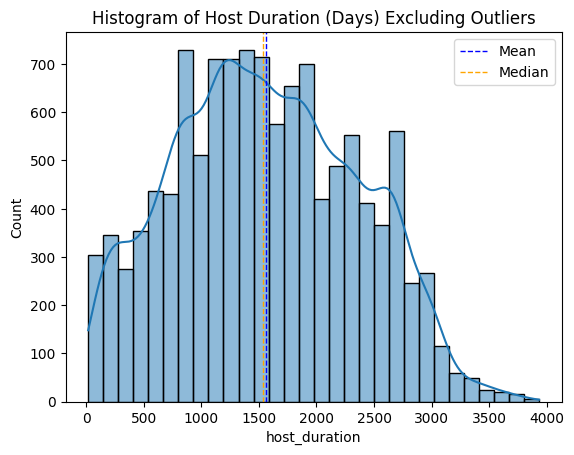

In [8]:
# Histogram of host_duration excluding outliers

# Calculate the mean and median
mean_duration = clean_df['host_duration'].mean()
median_duration = clean_df['host_duration'].median()
print(f"Mean Hosting Duration (excluding outliers): {mean_duration:.2f} days")
print(f"Median Hosting Duration (excluding outliers): {median_duration:.2f} days")
# Difference
print(f"Difference between Mean and Median: {mean_duration - median_duration:.2f} days")

# Plot histogram
sns.histplot(clean_df['host_duration'], 
             bins = 30, 
             kde = True)

# Add vertical lines for mean and median
plt.axvline(mean_duration, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'Mean')
plt.axvline(median_duration, color = 'orange', linestyle = 'dashed', linewidth = 1, label = 'Median')
plt.legend()

# Find most frequent bin
most_frequent_bin = clean_df['host_duration'].value_counts().idxmax()
print(f"Most Frequent Hosting Duration (bin): {most_frequent_bin} days")

plt.title('Histogram of Host Duration (Days) Excluding Outliers')
plt.show()

This histogram visualizes host_duration, excluding the outliers from the original dataset. There were 2 outliers.

The distribution of frequencies is relatively normal, close to a standard bell curve. The distribution does skew to the right, with the median being greater than the mean. The difference is only ~24 days, though. The skew does indicate that there are more new hosts than there are tenured hosts. The most frequent duration is 822.0 days. 

From a business standpoint, we see high frequencies around 1,000 to 1,800 days. This indicates a strong base of moderately experienced hosts. There appears to be some break point around 2,000 days, where the trend line begins to fall off. This could be a potential area to investigate: what happens around this length that causes hosts to drop their listings? 

The histogram looks similar in shape to the boxplot. Both have a cluster (25th-75th quartile in the boxplot) around the 1,000 to 2,000 range and the right skew of the histogram is mirrored in the boxplot's longer right-hand whisker. 

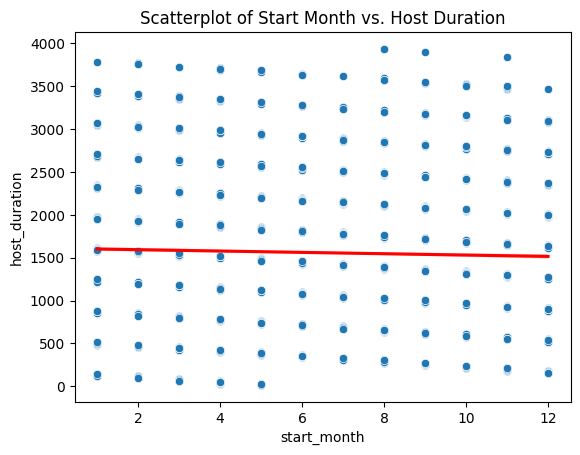

In [9]:
# Scatterplot of host_duration vs. start_month
# Try start_month as predictor of host_duration
sns.scatterplot(data = clean_df, 
                x = 'start_month', 
                y = 'host_duration')

plt.title('Scatterplot of Start Month vs. Host Duration')
plt.xlabel('Start Month')
plt.ylabel('Host Duration (Days)')

# Calculate & Display a Trend Line
# Plots are overlapping, so removing scatter points
sns.regplot(data = clean_df,
            x = 'start_month', 
            y = 'host_duration', 
            scatter = False, # Makes only the line, no scatter points
            color = 'red')
plt.show()

This scatterplot presents start_month against host_duration, using start_month as the predictor. 

It's clear from the points on the plot and the calculated trend line that there is little to no association between these two variables. When flipping the variables (using host_duration as the predictor instead), we can see that there is no association here either. 

start_month is seemingly numeric (values 1–12 for January–December), but it represents time categories rather than a true continuous scale. Scatterplots are best used for finding a correlation between two continious variables, which would explain why this comparison looks strange. 

Scatterplots assume both axes are quantitative. When you put start_month on the x-axis, Seaborn/Matplotlib treats it as numbers 1–12. That can work, but because there are only 12 discrete values, you get vertical stripes of points. Further, because the dataset is so large, it's difficult to visualize them with a simple Python plot. A dedicated visualization software like Tableau or PowerBI would help with that. 

It's hard to draw any conclusion from this scatterplot. If we were to continue to investigate this relationship, we'd need to adopt a different statistical method, recode the start_month variable to be continious if we wanted to generate a scatter plot, or find some different plot to use. If we were just investigating start_month, a better plot would be a histogram or boxplot. 

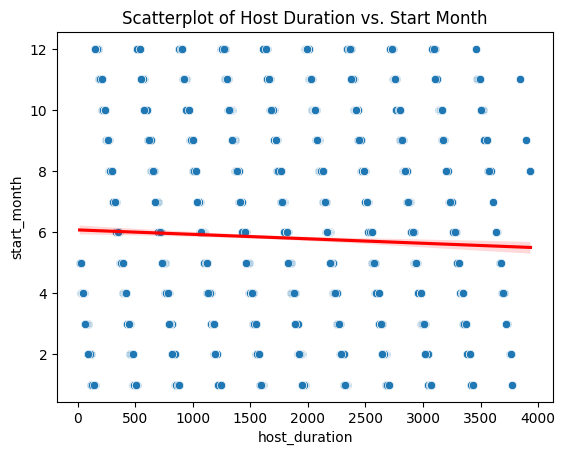

In [10]:
# Scatterplot of host_duration vs. start_month
# Try host_duration as predictor of start_month
sns.scatterplot(data = clean_df, 
                x = 'host_duration', 
                y = 'start_month')

plt.title('Scatterplot of Host Duration vs. Start Month')
plt.xlabel('Start Month')
plt.ylabel('Host Duration (Days)')

# Calculate & Display a Trend Line
# Plots are overlapping, so removing scatter points
sns.regplot(data = clean_df,
            x = 'host_duration', 
            y = 'start_month', 
            scatter = False, # Makes only the line, no scatter points
            color = 'red')
plt.show()

When we swap the variables from the previous scatterplot, we can see the same issue with start_month causing stripes instead of a true continious plot. 

Part 2: "Game of Thrones" Deaths\
Dataset: game-of-thrones-deaths-data.csv\
Data Source: https://github.com/washingtonpost/data-game-of-thrones-deaths\
Note: "The Washington Post has compiled an illustrated database of every single death in Game of Thrones over the course of its eight seasons, including background extras and animals. These numbers only include on-screen deaths."

In [11]:
# Read the Game of Thrones deaths dataset
URL = "https://raw.githubusercontent.com/washingtonpost/data-game-of-thrones-deaths/master/game-of-thrones-deaths-data.csv"
got_df = pd.read_csv(URL)
got_df.head() # Check if read in correctly

,order,season,episode,character_killed,killer,method,method_cat,reason,location,allegiance,importance
0,1,1,1,Waymar Royce,White Walker,Ice sword,Blade,Unknown,Beyond the Wall,"House Royce, Night’s Watch",2.0
1,2,1,1,Gared,White Walker,Ice sword,Blade,Unknown,Beyond the Wall,Night’s Watch,2.0
2,3,1,1,Will,Ned Stark,Sword (Ice),Blade,Deserting the Night’s Watch,Winterfell,Night’s Watch,2.0
3,4,1,1,Stag,Direwolf,Direwolf teeth,Animal,Unknown,Winterfell,NaN,1.0
4,5,1,1,Direwolf,Stag,Antler,Animal,Unknown,Winterfell,NaN,1.0


In [12]:
# Identify the top eight killers by number of deaths caused
# Each record has a "killer" column, indicating who/what caused the death
top_killers = got_df['killer'].value_counts().head(8)
print("Top 8 Killers by Number of Deaths Caused:")
print(top_killers) 

Top 8 Killers by Number of Deaths Caused:
killer
Wight               1602
Drogon              1426
Arya Stark          1278
Rhaegal              273
Cersei Lannister     199
Jon Snow             112
Stark soldier         96
Bolton soldier        91
Name: count, dtype: int64


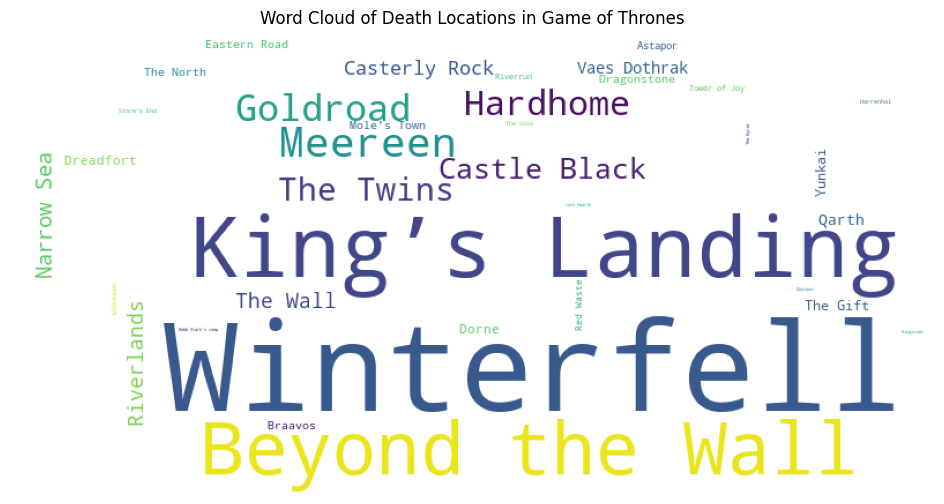

In [13]:
# Generate counts of deaths by location
location_counts = got_df['location'].value_counts()
# print(location_counts) # Check the counts, so we can see if the word cloud makes sense

# WordCloud generates the image using frequencies calculated from a single string input
# Because this column has words with spaces, apostraphes, and location names instead of single words
# We'd need to do thorough cleaning to make the text workable
# value_counts() gives us the frequencies directly without needing to clean the text
# We can instead use location_counts to generate the word cloud from frequencies

# Construct a WordCloud from frequencies
from wordcloud import WordCloud
wordcloud = WordCloud(
    width = 800,
    height = 400,
    background_color = 'white',
    colormap = 'viridis' 
).generate_from_frequencies(location_counts.to_dict()) # Use the value_counts directly as a frequency dictionary

# Generate figure 
plt.figure(figsize=(12, 6))
plt.axis('off') # Make the plot cleaner
plt.title("Word Cloud of Death Locations in Game of Thrones")
plt.imshow(wordcloud) # imshow() because wordcloud is an image